In [6]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import preprocessing

In [7]:
full_results = pd.read_csv('full_results.csv')
full_stats = pd.read_csv('FullKenPom_pt.csv')

print(full_results.shape)
print(full_stats.shape)
#full_stats

(1112, 11)
(1129, 27)


In [8]:
###mask test and train data###
res_test_mask = (full_results['Year'] == 2016) | (full_results['Year'] == 2017) | (full_results['Year'] == 2018)
stats_test_mask = (full_stats['Season'] == 2016) | (full_stats['Season'] == 2017) | (full_stats['Season'] == 2018)
res_train_mask = (full_results['Year'] < 2016)
stats_train_mask = (full_stats['Season'] < 2016)

res_data_test = full_results[res_test_mask]
stats_data_test = full_stats[stats_test_mask]
res_data_train = full_results[res_train_mask]
stats_data_train = full_stats[stats_train_mask]

#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

for i in range(len(res_data_test)):
    if res_data_test['Region Name'][i] == "First Four":
        res_data_test = res_data_test.drop(i)
for i in range(len(res_data_train)):
    if res_data_train['Region Name'][i] == "First Four":
        res_data_train = res_data_train.drop(i)
        
#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

res_data_train.head()

#res_data_test.tail()
#stats_data_test.tail()
#res_data_train.tail()
#stats_data_train.tail()
#data_test

,level_0,index,Unnamed: 0,Year,Round,Region Number,Region Name,SeedA,ScoreA,TeamA,TeamB,ScoreB,SeedB
0,1,1,1,2002,1,1,South,1,84,Duke,Winthrop,37,16
1,2,2,2,2002,1,1,South,2,86,Alabama,Florida Atlantic,78,15
2,3,3,3,2002,1,1,South,3,71,Pittsburgh,Central Connecticut St,54,14
3,4,4,4,2002,1,1,South,4,89,USC,UNC Wilmington,93,13
4,5,5,5,2002,1,1,South,5,75,Indiana,Utah,56,12


In [9]:
#these names match the kenpom stats csv
stats_vec = ["AdjTempo",
            "AdjOE",
            "AdjDE",
            "AdjEM",
            "seed",
            "ConfTournament",
            "SOSAdjEM",
            "NCSOSAdjEM",
            "O-D_eFG_Pct",
            "D-O_TO_Pct",
            "O-D_OR_Pct",
            "O-D_FT_Rate",
            "LastTenRecord"]

print(len(stats_vec))

13


In [10]:
# Move training data into 2 numpy arrays - data and labels (results)
N = len(res_data_train)

training_data = np.zeros((N,13))
training_labels = np.zeros((N,1))

for i in range(len(res_data_train)):
    year = res_data_train['Year'][i]
    teamA = res_data_train['TeamA'][i]
    teamB = res_data_train['TeamB'][i]
    score_diff = res_data_train['ScoreA'][i] - res_data_train['ScoreB'][i]
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        training_data[i][s] = stats_data_train[stat][indexA] - stats_data_train[stat][indexB]
    
    if (score_diff > 0):
        training_labels[i][0] = 1
    else:
        training_labels[i][0] = 0


In [11]:
# Move testing data into 2 numpy arrays - data and labels (results)
N = len(res_data_test)

testing_data = np.zeros((N,13))
testing_labels = np.zeros((N,1))

for i in range(len(res_data_test)):
#for i in range(5):
    year = res_data_test['Year'][i]
    teamA = res_data_test['TeamA'][i]
    teamB = res_data_test['TeamB'][i]
    score_diff = res_data_test['ScoreA'][i] - res_data_test['ScoreB'][i]
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        testing_data[i][s] = stats_data_test[stat][indexA] - stats_data_test[stat][indexB]
    
    if (score_diff > 0):
        testing_labels[i][0] = 1
    else:
        testing_labels[i][0] = 0


In [12]:
print(training_data.shape)
print(training_labels.shape)
print('\n')
print(testing_data.shape)
print(testing_labels.shape)

(882, 13)
(882, 1)


(189, 13)
(189, 1)


In [13]:
#Time to normalize the data
training_data = preprocessing.normalize(training_data, axis=0, norm='max')
testing_data = preprocessing.normalize(testing_data, axis=0, norm='max')


In [14]:
dtrain = xgb.DMatrix(training_data, label=training_labels,
                     feature_names=stats_vec)
dtest = xgb.DMatrix(testing_data, label=testing_labels,
                    feature_names=stats_vec)


In [15]:
param = {'objective':'multi:softprob'}
param['eval_metric'] = "merror"
param['num_class'] = 2 # 2 classes for a win or loss

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 500 #looks like it levels off at around 200
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-merror:0.291005	train-merror:0.15873
[1]	eval-merror:0.285714	train-merror:0.145125
[2]	eval-merror:0.306878	train-merror:0.131519
[3]	eval-merror:0.275132	train-merror:0.12585
[4]	eval-merror:0.269841	train-merror:0.104308
[5]	eval-merror:0.285714	train-merror:0.089569
[6]	eval-merror:0.285714	train-merror:0.075964
[7]	eval-merror:0.280423	train-merror:0.071429
[8]	eval-merror:0.280423	train-merror:0.064626
[9]	eval-merror:0.291005	train-merror:0.056689
[10]	eval-merror:0.280423	train-merror:0.05102
[11]	eval-merror:0.275132	train-merror:0.05102
[12]	eval-merror:0.301587	train-merror:0.038549
[13]	eval-merror:0.280423	train-merror:0.035147
[14]	eval-merror:0.269841	train-merror:0.026077
[15]	eval-merror:0.269841	train-merror:0.026077
[16]	eval-merror:0.26455	train-merror:0.020408
[17]	eval-merror:0.26455	train-merror:0.018141
[18]	eval-merror:0.26455	train-merror:0.017007
[19]	eval-merror:0.26455	train-merror:0.012472
[20]	eval-merror:0.26455	train-merror:0.011338
[21]	eval-m

[194]	eval-merror:0.232804	train-merror:0
[195]	eval-merror:0.232804	train-merror:0
[196]	eval-merror:0.232804	train-merror:0
[197]	eval-merror:0.238095	train-merror:0
[198]	eval-merror:0.232804	train-merror:0
[199]	eval-merror:0.232804	train-merror:0
[200]	eval-merror:0.232804	train-merror:0
[201]	eval-merror:0.232804	train-merror:0
[202]	eval-merror:0.232804	train-merror:0
[203]	eval-merror:0.232804	train-merror:0
[204]	eval-merror:0.232804	train-merror:0
[205]	eval-merror:0.232804	train-merror:0
[206]	eval-merror:0.232804	train-merror:0
[207]	eval-merror:0.232804	train-merror:0
[208]	eval-merror:0.232804	train-merror:0
[209]	eval-merror:0.232804	train-merror:0
[210]	eval-merror:0.232804	train-merror:0
[211]	eval-merror:0.232804	train-merror:0
[212]	eval-merror:0.232804	train-merror:0
[213]	eval-merror:0.232804	train-merror:0
[214]	eval-merror:0.232804	train-merror:0
[215]	eval-merror:0.238095	train-merror:0
[216]	eval-merror:0.238095	train-merror:0
[217]	eval-merror:0.238095	train-m

[390]	eval-merror:0.232804	train-merror:0
[391]	eval-merror:0.232804	train-merror:0
[392]	eval-merror:0.227513	train-merror:0
[393]	eval-merror:0.227513	train-merror:0
[394]	eval-merror:0.227513	train-merror:0
[395]	eval-merror:0.227513	train-merror:0
[396]	eval-merror:0.227513	train-merror:0
[397]	eval-merror:0.227513	train-merror:0
[398]	eval-merror:0.227513	train-merror:0
[399]	eval-merror:0.227513	train-merror:0
[400]	eval-merror:0.227513	train-merror:0
[401]	eval-merror:0.227513	train-merror:0
[402]	eval-merror:0.227513	train-merror:0
[403]	eval-merror:0.227513	train-merror:0
[404]	eval-merror:0.227513	train-merror:0
[405]	eval-merror:0.227513	train-merror:0
[406]	eval-merror:0.227513	train-merror:0
[407]	eval-merror:0.227513	train-merror:0
[408]	eval-merror:0.227513	train-merror:0
[409]	eval-merror:0.227513	train-merror:0
[410]	eval-merror:0.227513	train-merror:0
[411]	eval-merror:0.227513	train-merror:0
[412]	eval-merror:0.227513	train-merror:0
[413]	eval-merror:0.227513	train-m

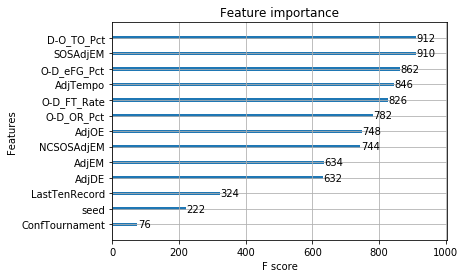

In [17]:
### Shows the weight of each stat vector ###
xgb.plot_importance(bst)

In [18]:
outcome = bst.predict(dtest)
outcome

array([[1.20055171e-04, 9.99879956e-01],
       [2.79563137e-05, 9.99971986e-01],
       [1.94901635e-03, 9.98051047e-01],
       [1.00666441e-01, 8.99333537e-01],
       [1.39910415e-01, 8.60089600e-01],
       [2.09241986e-01, 7.90758014e-01],
       [2.20595896e-02, 9.77940440e-01],
       [9.99168634e-01, 8.31407786e-04],
       [1.90402461e-05, 9.99980927e-01],
       [1.11866994e-02, 9.88813341e-01],
       [6.88784290e-04, 9.99311209e-01],
       [7.97263440e-03, 9.92027342e-01],
       [3.26021351e-02, 9.67397869e-01],
       [3.18005413e-01, 6.81994557e-01],
       [1.45156652e-01, 8.54843378e-01],
       [9.61072385e-01, 3.89276370e-02],
       [2.03922937e-05, 9.99979615e-01],
       [4.76832156e-06, 9.99995232e-01],
       [1.34686183e-03, 9.98653054e-01],
       [5.04186435e-04, 9.99495745e-01],
       [3.89347272e-03, 9.96106565e-01],
       [3.53426456e-01, 6.46573544e-01],
       [1.38039008e-01, 8.61961007e-01],
       [8.72243822e-01, 1.27756193e-01],
       [1.416604